# Setting up Environment for google.colab

In [1]:
!pip install torch==1.7.0

# Importing Utils and Reading Data

In [2]:
import torch

dev="cuda" if torch.cuda.is_available() else "cpu"
if dev=="cuda":
  print (f"Available gpu is :{torch.cuda.get_device_name (dev)}.")
else:
  print (f"GPU not available :{torch.cuda.get_device_name(dev)}.")

Available gpu is :Tesla P100-PCIE-16GB.


In [3]:
import sys
sys.path=["../input/geffnet-20200820"]+sys.path

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch import multiprocessing as mp
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import AutoTokenizer, AutoModel
import os, cv2 as cv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import geffnet
import albumentations as A
from sklearn.metrics import f1_score

In [5]:
csv="../input/shopee-product-matching/train.csv"
img_dir="../input/shopee-product-matching/train_images/"

In [6]:
dataset=pd.read_csv (csv)
dataset.head(5)

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [7]:
# Preparing dataset

class ShopData (Dataset):
    
    def __init__ (self, df=dataset, img_dir=img_dir, tokenizer=None,
                  transformer=A.Compose([A.Resize(256, 256), A.Normalize()]), device="cpu"):
      
        self.df=df   #imported cvs table
        self.img_dir=img_dir #image directory path
        self.transform=transformer
        self.tokenizer=tokenizer
        self.device=device
    
    def __len__ (self):
        return (len(self.df))
    
    def __getitem__(self, index):
      
        if torch.is_tensor(index):
          index=index.tolist()
      
        row=self.df.iloc[index] #row item
        path=os.path.join (self.img_dir, row.image) #storing image path

        img=cv.imread(path)
        img=cv.cvtColor (img, cv.COLOR_BGR2RGB)
        text=row.title

        if self.tokenizer is not None:
          text=self.tokenizer(text, padding='max_length', truncation=True, max_length=100, return_tensors='pt')
          attention_mask=text['attention_mask'][0]
          input_ids=text['input_ids'][0]
        
        if self.transform is not None:
          img=self.transform(image=img)['image'].astype(np.float32).transpose(2, 0, 1)
        
        return {'posting_id':row.posting_id,
                'image': torch.tensor(img).to(self.device),
                'input_ids':input_ids.to(self.device),
                'attention_mask':attention_mask.to(self.device)}

# Praparing Model

In [8]:
text_model=AutoModel.from_pretrained('../input/bert-base-uncased')
tokenizer=AutoTokenizer.from_pretrained('../input/bert-base-uncased')
image_model=geffnet.create_model('tf_efficientnet_b0_ns', pretrained=None)

  ## Network

In [9]:
class Network (nn.Module):
    def __init__ (self):
        super(Network, self).__init__()
        self.bert=text_model
        self.enet=image_model
        self.feat = nn.Linear(self.enet.classifier.in_features+self.bert.config.hidden_size, 512)
        self.relu=nn.ReLU()

        self.enet.classifier = nn.Identity()

    def forward (self, image, input_ids, attention_mask):
        image=self.enet (image.type(torch.cuda.FloatTensor))
        text=self.bert (input_ids, attention_mask)
        cat=torch.cat ([image, text[1]], dim=1)
        cat=self.feat (cat)
        cat=self.relu (cat)
        cat=nn.functional.normalize(cat)

        return cat

# Finding Similar Embeddings with Cosine Similarity

In [10]:
BATCH_SIZE=32

model=Network().to(dev)
state_dict=torch.load('../input/shopee-b0-bert/b0ns_256_bert_20ep_fold0_epoch27.pth')['model_state_dict']
state_dict = {k: state_dict[k] for k in list(state_dict.keys())[:-1]}
model.load_state_dict(state_dict, strict=True)

data=ShopData(device=dev, tokenizer=tokenizer)
data_loader=DataLoader(data, batch_size=BATCH_SIZE)

In [11]:
embeddings=[]
model.train(False)
posting_id=[]
with torch.no_grad():
    for d in tqdm(data_loader): 
        posting, img, input_ids, attention_mask = d['posting_id'], d['image'], d['input_ids'], d['attention_mask']
        out = model(img, input_ids, attention_mask)
        embed = out.detach().cpu().numpy()
        embeddings.append(embed)
        posting_id.append(posting)

100%|██████████| 1071/1071 [12:44<00:00,  1.40it/s]


In [12]:
embeds=np.concatenate(embeddings)
pids=np.concatenate(posting_id)

In [13]:
sim=cosine_similarity(embeds)

In [14]:
idx=np.where(sim[3, :]*(sim[3, :]>0.5))

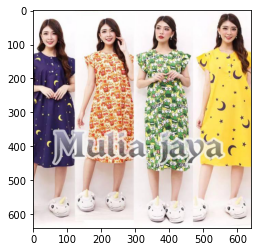

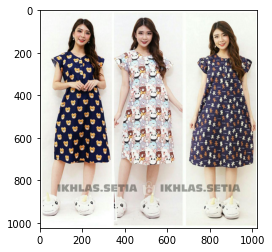

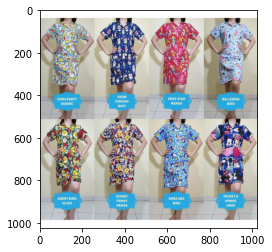

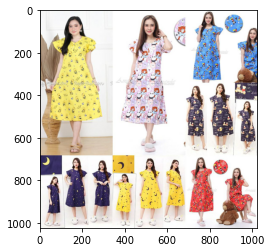

In [15]:
for i in pids[idx]:
  ind=dataset.posting_id.to_list().index(i)
  path_to_image="../input/shopee-product-matching/train_images/"
  img=plt.imread(path_to_image+dataset.iloc[ind].image)
  plt.imshow(img)
  plt.show()

In [16]:
tmp = dataset.groupby('label_group').posting_id.agg('unique').to_dict()
dataset['target'] = dataset.label_group.map(tmp)

In [17]:
from IPython.display import clear_output

Currently F1 score at distance < 0.8999999999999999: 0.5598040385798427
Max F1 score 0.8971899874683678 at threshold < 0.6


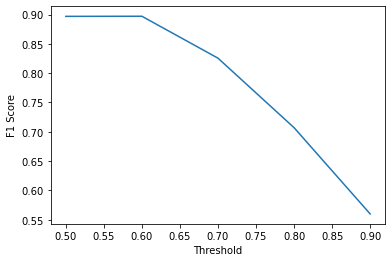

In [18]:
scores=[]
threshold=np.arange(0.5, 1, 0.1)
for thresh in threshold:
  idxs=[]
  for i in range (sim.shape[0]):
    idxs.append(np.argwhere(sim[i]>=thresh).reshape(1, -1).tolist()[0])
  pst=[]
  for i in idxs:
    pst.append(dataset.posting_id.iloc[i].tolist())
  dataset['predictions']=pst
  f1=[]
  for i in range (len(dataset)):
      a=len(np.intersect1d(dataset.iloc[i].target, dataset.iloc[i].predictions))
      b=len(dataset.iloc[i].target) + len(dataset.iloc[i].predictions)
      f1.append(2*a/b)
  scores.append(np.mean(f1))
  
  clear_output (True)
  print(f"Currently F1 score at distance < {thresh}: {scores[-1]}")
  print (f"Max F1 score {max(scores)} at threshold < {threshold[scores.index(max(scores))]}")
  plt.plot (threshold[:len(scores)], scores)
  plt.xlabel("Threshold")
  plt.ylabel("F1 Score")
  plt.show()

In [19]:
th=np.argwhere(sim>0.5)
predictions={i[0]:dataset.posting_id.values[i[0:]] for i in th}
del th

In [20]:
dataset['predictions']=list(predictions.values())
del predictions

In [29]:
idxs=[]
for i in range (sim.shape[0]):
    idxs.append(np.argwhere(sim[i]>=0.6).reshape(1, -1).tolist()[0])
pst=[]
for i in idxs:
    pst.append(dataset.posting_id.iloc[i].tolist())
dataset['predictions']=pst

In [30]:
dataset.head(5)

,posting_id,image,image_phash,title,label_group,target,predictions
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]","[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]","[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]","[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]",[train_2406599165]
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]","[train_3369186413, train_921438619]"


In [31]:
tmp = dataset.groupby('label_group').posting_id.agg('unique').to_dict()
dataset['target'] = dataset.label_group.map(tmp)

In [32]:
dataset.head(5)

,posting_id,image,image_phash,title,label_group,target,predictions
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]","[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]","[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]","[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]",[train_2406599165]
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]","[train_3369186413, train_921438619]"


# F1 Score

In [33]:
f1=[]
for i in range (len(dataset)):
    a=len(np.intersect1d(dataset.iloc[i].target, dataset.iloc[i].predictions))
    b=len(dataset.iloc[i].target) + len(dataset.iloc[i].predictions)
    f1.append(2*a/b)
print ("F1 Score: ", np.mean(f1))

F1 Score:  0.8971899874683678
